# Predict Behavior of Inverter & Electric Motor

### Problem Description

- To achieve a desired torque the inverter needs to apply a specific voltage to electric motor
- Inverter itself receives a signal from the controller (elementary vector)
- Controller signal (elementary vector) sent to inverter determines the state of the switches in the inverter (inverter switching states)
- An inverter is a power electronic devices which converts DC to AC voltage, which the motor requires
- Motor speed is regulated via AC voltages of varying amplitude and frequency

### Objective

- Predict behavior of inverter and electric motor
- Specifically, given a selected elementary vector (controller signal) predict currents at a future point in time which minimizes deviation from a set point

<img src="https:////images.ctfassets.net/qthuj5q9c91u/a0ArrJcPn1ZcR0YjSSoLi/4798acd7e083e6cc9511e81bfaddce4a/controller_inverter_motor.png" title="article4_controller_inverter_motor" alt="article4_controller_inverter_motor" />

### Data Source

Experiment description, diagrams, and data provided by: Soren Hanke, Oliver Wallscheid, Joachim Bocker Department of Power Electronics and Electrical Drives, Paderborn University, 33095 Paderborn, Germany, ∗E-mail: hanke@lea.upb.de

https://www.kaggle.com/datasets/hankelea/system-identification-of-an-electric-motor

### More info

### Model Predictive Control (MPC)

The controller can regulate the motor currents by selecting appropriate **elementary vectors**.

1) Measurement of id, iq, ε at time point k
   
2) Prediction of the currents at k + 1 for the different elementary vectors that can be applied
3) Selection of the elementary vector that brings both
currents as close as possible to the set points
1) Apply the selected elementary vector for one cycle (here between k and k + 1)
2) Repeat steps 1-4 for the next cycle beginning at k + 1

### Elementary Vector Represents the Inverter State

<img src="https://images.ctfassets.net/qthuj5q9c91u/3Tkg3Pzb5CYhecS6GmCDoi/83022ca45f8907f5f27aa68d513ba287/inverter_switching_states.png" title="article4_inverter_switching_states" alt="article4_inverter_switching_states">

### Targeted Set Points

Again our targets are the d and q currents at time k + 1.

**"An everyday example is the cruise control on a car, where ascending a hill would lower speed if constant engine power were applied. The controller's PID algorithm restores the measured speed to the desired speed with minimal delay and overshoot by increasing the power output of the engine in a controlled manner."**

https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller

<img src="https://images.ctfassets.net/qthuj5q9c91u/2sjnEn9TlEw9ySuokdQBUa/fdd4fda2709e29a245bf408902a8b5c3/targeted_set_points.png" title="article4_targeted_set_points" alt="article4_targeted_set_points"/>


###  Industry Relevance

"An important challenge in the design and real-time implementation of MPC is having a accurate predictive model that also does not require excessive real-time computation. "

https://www.sciencedirect.com/science/article/abs/pii/S0952197623000623



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.formula.api as smf
from sklearn import model_selection, metrics
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',500)

# Get Data 

https://www.kaggle.com/datasets/hankelea/system-identification-of-an-electric-motor

In [4]:
original_data = pd.read_csv("./Dataset_Electric_Motor.csv")

In [5]:
#electric_motor_df = original_data.copy() #save ram
electric_motor_df = original_data.iloc[::100,:] #reduce dataset while in development
electric_motor_df.head(5)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
0,-81.45802,229.52930,2.240254,5,6,-105.73820,167.36170
100,-101.20220,194.92640,2.752704,3,6,-48.62930,159.77730
200,-65.31933,62.02916,2.728086,5,6,-95.14313,54.85019
300,-155.71220,85.02038,-0.433627,3,4,-183.91430,98.38583
400,-168.86510,67.30013,-0.083969,1,7,-160.16250,64.40960


# Explore Data

In [6]:
electric_motor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409633 entries, 0 to 40963200
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id_k       409633 non-null  float64
 1   iq_k       409633 non-null  float64
 2   epsilon_k  409633 non-null  float64
 3   n_k        409633 non-null  int64  
 4   n_1k       409633 non-null  int64  
 5   id_k1      409633 non-null  float64
 6   iq_k1      409633 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 21.9 MB


In [7]:
electric_motor_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_k,409633.0,-99.690859,61.269943,-239.997600,-147.242400,-94.142900,-48.027680,-0.000709
iq_k,409633.0,93.468820,59.266560,0.000669,44.143610,86.428790,138.505200,239.987000
epsilon_k,409633.0,0.012900,1.808286,-3.141590,-1.548557,0.034533,1.583191,3.141574
n_k,409633.0,3.789255,2.079335,1.000000,2.000000,4.000000,6.000000,7.000000
n_1k,409633.0,3.774466,2.078105,1.000000,2.000000,4.000000,6.000000,7.000000
id_k1,409633.0,-98.893393,64.397540,-283.511300,-148.004900,-94.370770,-47.915370,66.211960
iq_k1,409633.0,94.710610,61.688302,-9.395191,44.149770,86.832340,139.339400,330.474700


In [8]:
electric_motor_df.isna().sum()

id_k         0
iq_k         0
epsilon_k    0
n_k          0
n_1k         0
id_k1        0
iq_k1        0
dtype: int64

In [9]:
corr_table = electric_motor_df.corr()

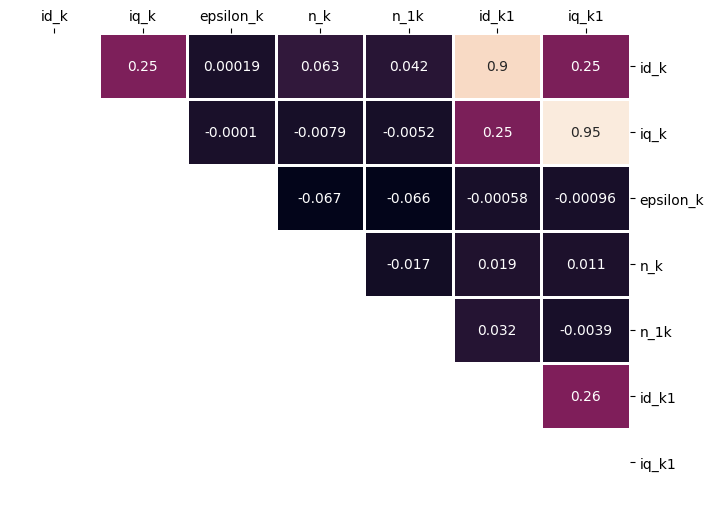

In [10]:
plt.figure(figsize = (8,6))
heat_map = sns.heatmap(data=corr_table,\
                        mask =  np.tri(N=corr_table.shape[0],M=corr_table.shape[1]),\
                        annot=True,linewidth=.75, cbar=False)
heat_map.xaxis.tick_top()
heat_map.yaxis.tick_right()
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

In [11]:
sample_df = electric_motor_df.iloc[::10000,:]

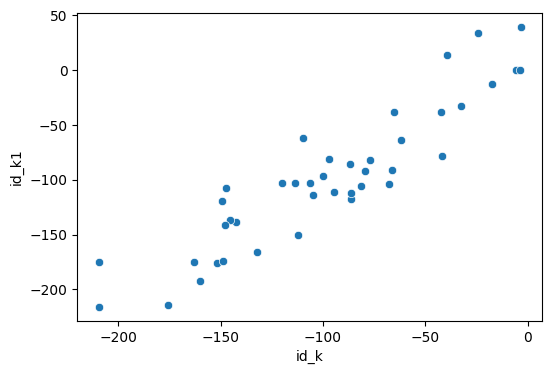

In [12]:
plt.figure(figsize = (6,4))
scatter_id = sns.scatterplot(data=sample_df, \
                            y=sample_df["id_k1"], \
                            x="id_k") 
plt.show()

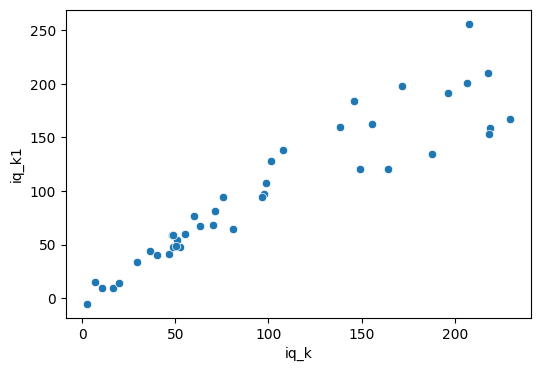

In [13]:
plt.figure(figsize = (6,4))
scatter_id = sns.scatterplot(data=sample_df, \
                            y=sample_df["iq_k1"], \
                            x="iq_k") 
plt.show()

# Features (X) and Targets (y)

<img src="https://images.ctfassets.net/qthuj5q9c91u/q5PZl9gjF2HLlcxSr3eu8/86e8eef4d4736ceb6881c7fe3ea3739b/features_and_targets.png" title="article4_features_and_targets" alt="article4_features_and_targets">

In [14]:
# features
X = electric_motor_df.iloc[:,:-2]
X.head(5)

,id_k,iq_k,epsilon_k,n_k,n_1k
0,-81.45802,229.52930,2.240254,5,6
100,-101.20220,194.92640,2.752704,3,6
200,-65.31933,62.02916,2.728086,5,6
300,-155.71220,85.02038,-0.433627,3,4
400,-168.86510,67.30013,-0.083969,1,7


In [15]:
# targets
y_i_d = electric_motor_df['id_k1']
y_i_q = electric_motor_df['iq_k1']

#  Simple Linear Regression - Baseline

- Predict based only on current at time k (id_k, iq_k)


<img src="https://images.ctfassets.net/qthuj5q9c91u/4Feg91f0m0LwkP75fqSZ8o/cd7c33d9b2229b941020a71b93d6a4b9/Simple_Linear_Regression.png" title="article4_Simple_Linear_Regression" alt="article4_Simple_Linear_Regression">

In [16]:
#  train/test split
X_id_train, X_id_test, y_id_train,y_id_test =\
      model_selection.train_test_split(X['id_k'],y_i_d,\
                                       train_size = 0.8,\
                                       random_state=1)


In [17]:
# simple regression model for id_k1

X_id_train = np.reshape(X_id_train,(-1,1))
X_id_test = np.reshape(X_id_test,(-1,1))

# fit
model_id = LinearRegression().fit(X_id_train, y_id_train)
train_r2 = model_id.score(X_id_train, y_id_train)
coefficient_id_k = model_id.coef_
intercept_id_k = model_id.intercept_

print(f"train R^2: {train_r2:.2f}")
print(f"id_k1 = {coefficient_id_k[0]:.2f}*(id_k) {intercept_id_k:.2f}")

# predict
pred_id = model_id.predict(X_id_test)
test_r2 = model_id.score(X_id_test,y_id_test)

#evaluate
model_id_mse = metrics.mean_squared_error(y_id_test,pred_id)
model_id_mae = metrics.mean_absolute_error(y_id_test,pred_id)

print(f"test R^2: {test_r2:.2f} | Mean Squared Error: {model_id_mse:.2f} A²")
print(f"Mean Absolute Error: {model_id_mae:.2f} A")


train R^2: 0.81
id_k1 = 0.95*(id_k) -4.46
test R^2: 0.81 | Mean Squared Error: 782.33 A²
Mean Absolute Error: 23.34 A


In [18]:

#  train/test split

X_iq_train, X_iq_test, y_iq_train,y_iq_test =\
      model_selection.train_test_split(X['iq_k'],y_i_q,random_state=1)

In [19]:
# simple regression model for iq_k1
X_iq_train = np.reshape(X_iq_train,(-1,1))
X_iq_test = np.reshape(X_iq_test,(-1,1))

# fit
model_iq = LinearRegression().fit(X_iq_train, y_iq_train)
train_r2_iq = model_id.score(X_id_train, y_id_train)
coefficient_iq_k = model_iq.coef_
intercept_iq_k = model_iq.intercept_

print(f"train R^2: {train_r2_iq:.2f}")
print(f"iq_k1= {coefficient_iq_k[0]:.2f}*(iq_k) + {intercept_iq_k:.2f}")


# predict
pred_iq = model_id.predict(X_iq_test)
test_r2_iq = model_id.score(X_iq_test,y_iq_test)

#evaluate
model_iq_mse = metrics.mean_squared_error(y_iq_test,pred_iq)
model_iq_mae = metrics.mean_absolute_error(y_iq_test,pred_iq)

print(f"test R^2: {test_r2_iq:.2f} | Mean Squared Error: {model_iq_mse:.2f} A²")
print(f"Mean Absolute Error: {model_iq_mae:.2f} A")

train R^2: 0.81
iq_k1= 0.98*(iq_k) + 2.65
test R^2: 0.86 | Mean Squared Error: 518.78 A²
Mean Absolute Error: 16.58 A


# Cost Function

Root mean square of error (RMSE). Since two targets must consider error for d and q currents.

<img src="https://images.ctfassets.net/qthuj5q9c91u/181G5lZkFYotQdF6eQx9uq/b2590673ccba0ea9474036ae207060f0/cost_function.png" title="article4_cost_function" alt="article4_cost_function"/>

*Will calcualte RMSE on test data.


# Can we improve on this?

In [20]:
rmse_simple_linear_regression = np.sqrt(model_id_mse + model_iq_mse)
print(f"RMSE for simple linear regression: {rmse_simple_linear_regression:.2f} A")

RMSE for simple linear regression: 36.07 A


# Model A - Multiple Linear Regression

- Use all available inputs for target prediction

<img src="https://images.ctfassets.net/qthuj5q9c91u/1YiUuorITcaOSoNs7PUC2F/9aca41662c3a785eaa5f2997415273da/Model_A_no_feature_eng.png" title="article4_Model_A_no_feature_eng" alt="article4_Model_A_no_feature_eng"/>

In [21]:
model_A_iq = LinearRegression()
model_A_id = LinearRegression()

models_A_v1 = [{"model":model_A_iq,
             "features": X,
             "target": y_i_q},
             {"model":model_A_id,
             "features": X,
             "target": y_i_d}]

In [22]:
# The evaluate_model function fits a linear regression model to train data
# and predicts on test data. Also returns accuracy scores.

def evaluate_model(model,X_train, X_test, y_train, y_test ):
    # train
    trained_model = model.fit(X_train, y_train)
    train_r2 = trained_model.score(X_train,y_train)
    coefficients = trained_model.coef_
    intercept = trained_model.intercept_

    coefficients_list = list(zip(coefficients, X_train.columns))
    
    #print regression equation 
    equation = "y = "
    for coeff in coefficients_list:
        equation = equation + " + " + "{:.4f}*({})".format(coeff[0],coeff[1])

    equation = equation + " + " + "{:.4f}".format(intercept)
    
    print(f"train R^2: {train_r2:.3f}")
    print(equation)
    
    
    #predict
    predictions = trained_model.predict(X_test)
    test_r2 = trained_model.score(X_test,y_test)
    
    #evaluate
    test_MSE = metrics.mean_squared_error(y_test, predictions)
    test_MAE = metrics.mean_absolute_error(y_test, predictions)

    print(f"test R^2: {test_r2:.3f}")
    print(f"Mean Squared Error: {test_MSE:.3f} A²")
    print(f"Mean Absolute Error: {test_MAE:.3f} A")

    return test_MSE

In [23]:
model_A_v1_scores = []
for m in models_A_v1:
    X_train,X_test,y_train,y_test =\
          model_selection.train_test_split(m['features'],m["target"],\
                                        train_size=0.8, random_state=1)
    model_mse = \
    evaluate_model(model = m["model"],\
                X_train = X_train, \
                X_test = X_test,\
                y_train = y_train,\
                 y_test = y_test)
    model_A_v1_scores.append(model_mse)
    print("*"*20)

print("Mean Squared Error: (model_A_iq, model_A_id)")
print(model_A_v1_scores)


train R^2: 0.896
y =  + 0.0105*(id_k) + 0.9824*(iq_k) + 0.0201*(epsilon_k) + 0.5158*(n_k) + 0.0283*(n_1k) + 1.8741
test R^2: 0.896
Mean Squared Error: 395.550 A²
Mean Absolute Error: 13.865 A
********************
train R^2: 0.814
y =  + 0.9447*(id_k) + 0.0214*(iq_k) + -0.1296*(epsilon_k) + -1.1868*(n_k) + -0.2145*(n_1k) + -1.3860
test R^2: 0.813
Mean Squared Error: 774.377 A²
Mean Absolute Error: 22.726 A
********************
Mean Squared Error: (model_A_iq, model_A_id)
[395.5499242907745, 774.3767788715248]


In [24]:
model_A_v1_test_RMSE = np.sqrt(sum(model_A_v1_scores))
print(f"Model A v1 test data RMSE: {model_A_v1_test_RMSE:.2f}")

Model A v1 test data RMSE: 34.20


# Feature Engineering

In [25]:
sample_df2 = electric_motor_df.sample(frac=0.05)
sample_df2.head(3)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
26151200,-88.85652,145.71130,1.139075,1,4,-75.45686,141.47810
28339700,-40.55131,137.79740,2.653876,2,7,-23.09339,182.82230
20420300,-35.57716,56.41778,2.538663,2,6,-28.24612,70.79226


### Intuition for New Features and Models

### Model B - Distribution Plots
- Seperate model to predict dq currents based on current switch state vector n_k
  
<img src="https://images.ctfassets.net/qthuj5q9c91u/19rHdFzKHPbGNb1PGXHgax/523d80610fc908b7ebb78fc699f292af/ModelB.png" title="article4_ModelB" alt="article4_ModelB">

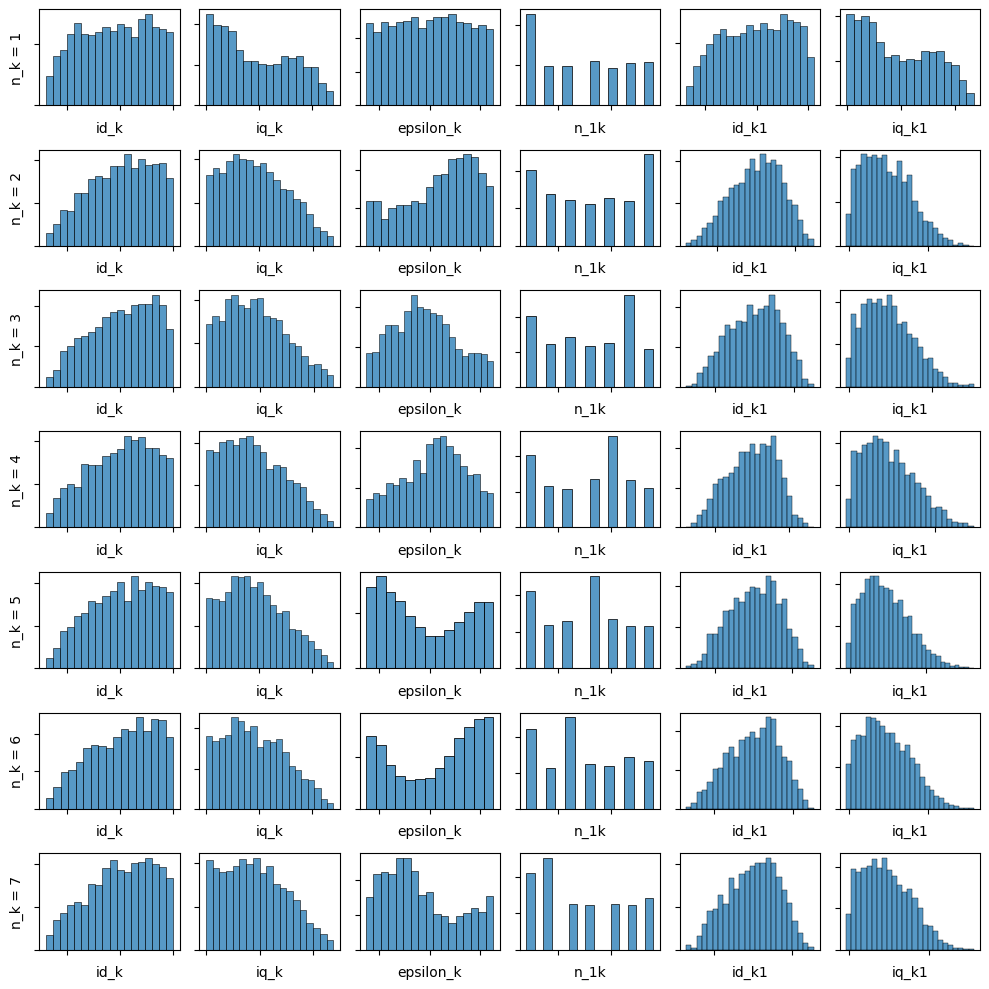

In [26]:
group_by_column = 'n_k'
columns_to_analyze = [col for col in sample_df2.columns if col != 'n_k']
figure, axs = plt.subplots(nrows=7, ncols=len(columns_to_analyze), figsize=(10, 10))

# sns.set(font_scale=2)
for k, group in sample_df2.groupby('n_k'):
    for i, col in enumerate(columns_to_analyze):
        ax = axs[k-1, i]  # Get the current axis
        sns.histplot(data=group, x=col, ax=ax)
        ax.set(ylabel='')
        
        
        if i == 0:
            ax.set_ylabel(f'n_k = {k}')  # Set y-label for each row
        
        # if k == len(axs) - 1:
        #     ax.set_xlabel(col)  # Set x-label for the last row

        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()

### Insights Model B

- Some elementary vectors at time k - 1 more likely given currently selected elementary vector n_k.
- For example, notice when n_k=1 likely the previous elementary vector state was n_1k=1.
- For some elementary vectors, n_k, the motor angle, epsilon_k , either follows a unimodal or bimodal distribution.
- The distribution plots above will serve as the intuition behind model B. 
- In Model B we group data by current elementary vector, n_k, and build a regression model for each of the 7 possible states. (n_k=1, n_k=2, ..., n_k=7)

### Model C - Distribution Plots

**What if we not only group by n_k but also the previous elementary vector n_1k?**

- Create a state change features which represents elementary vector state at time k -1 and time k.
- 49 possible state changes and thus 49 models, but fewer input features.
- For example 1 -> 1 is a seperate model from 2 -> 5.
  
<img src="https://images.ctfassets.net/qthuj5q9c91u/51al8UmQxCLPTO4i9jNBf5/4f3ccc21d35c6f713b8d691af7cbbf9b/ModelC.png" title="article4_ModelC" alt="article4_ModelC">

In [27]:
def elementary_vector_change(df_subset):
    new_n_1k = df_subset["n_1k"].astype(str)
    new_n_k = df_subset["n_k"].astype(str)
    return new_n_1k + '-->' + new_n_k

sample_df2['state_change'] = sample_df2[["n_1k","n_k"]].\
    apply(elementary_vector_change,axis=1)

print(sample_df2.head(5))

print(sample_df2['state_change'].nunique())
print(sample_df2['state_change'].value_counts(normalize=True)[:10])

              id_k       iq_k  epsilon_k  n_k  n_1k     id_k1      iq_k1  \
26151200 -88.85652  145.71130   1.139075    1     4 -75.45686  141.47810   
28339700 -40.55131  137.79740   2.653876    2     7 -23.09339  182.82230   
20420300 -35.57716   56.41778   2.538663    2     6 -28.24612   70.79226   
12129900 -43.94709   35.76604   2.130587    5     4 -62.12860   26.10093   
2037300  -79.49921  188.03950  -2.722183    1     5 -65.18996  182.88920   

         state_change  
26151200        4-->1  
28339700        7-->2  
20420300        6-->2  
12129900        4-->5  
2037300         5-->1  
49
state_change
1-->1    0.055561
6-->3    0.031882
5-->4    0.031540
3-->6    0.031296
4-->5    0.030808
2-->7    0.030710
7-->2    0.029831
1-->6    0.027390
4-->1    0.026999
7-->1    0.026365
Name: proportion, dtype: float64


In [28]:
unique_state_changes = sample_df2['state_change'].unique()
state_change_to_integer = {state_change: idx for idx, state_change in enumerate(unique_state_changes)}
# print(state_change_to_integer)
sample_df2['state_integer'] = sample_df2['state_change'].map(state_change_to_integer)

In [29]:
sample_df2[(sample_df2['n_k'] == 1) & (sample_df2['n_1k']==1)].head(10)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1,state_change,state_integer
5236800,-13.99236,28.640040,2.940277,1,1,-11.018760,27.834170,1-->1,20
7821900,-1.72722,73.245590,-1.817208,1,1,3.424817,71.298270,1-->1,20
26409400,-155.39980,105.542400,1.141140,1,1,-145.335900,103.853400,1-->1,20
7581800,-204.87910,4.691106,-2.749848,1,1,-204.004800,4.555696,1-->1,20
28720800,-200.28430,14.440400,0.868378,1,1,-198.403900,14.272000,1-->1,20
36158000,-70.06106,25.740210,0.729966,1,1,-67.031070,25.053220,1-->1,20
39752700,-22.93112,206.842100,1.286151,1,1,-12.776520,202.053900,1-->1,20
20373900,-226.57030,7.029206,-1.999258,1,1,-224.993300,7.079657,1-->1,20
15544500,-190.31110,3.787890,-2.416440,1,1,-189.049100,3.578584,1-->1,20
33249200,-177.02240,42.866710,2.113818,1,1,-172.326600,42.599410,1-->1,20


['id_k', 'iq_k', 'epsilon_k', 'id_k1', 'iq_k1']


/var/folders/7k/_d7zxxwn68d0nz09bpsl17700000gp/T/ipykernel_4455/3842390254.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


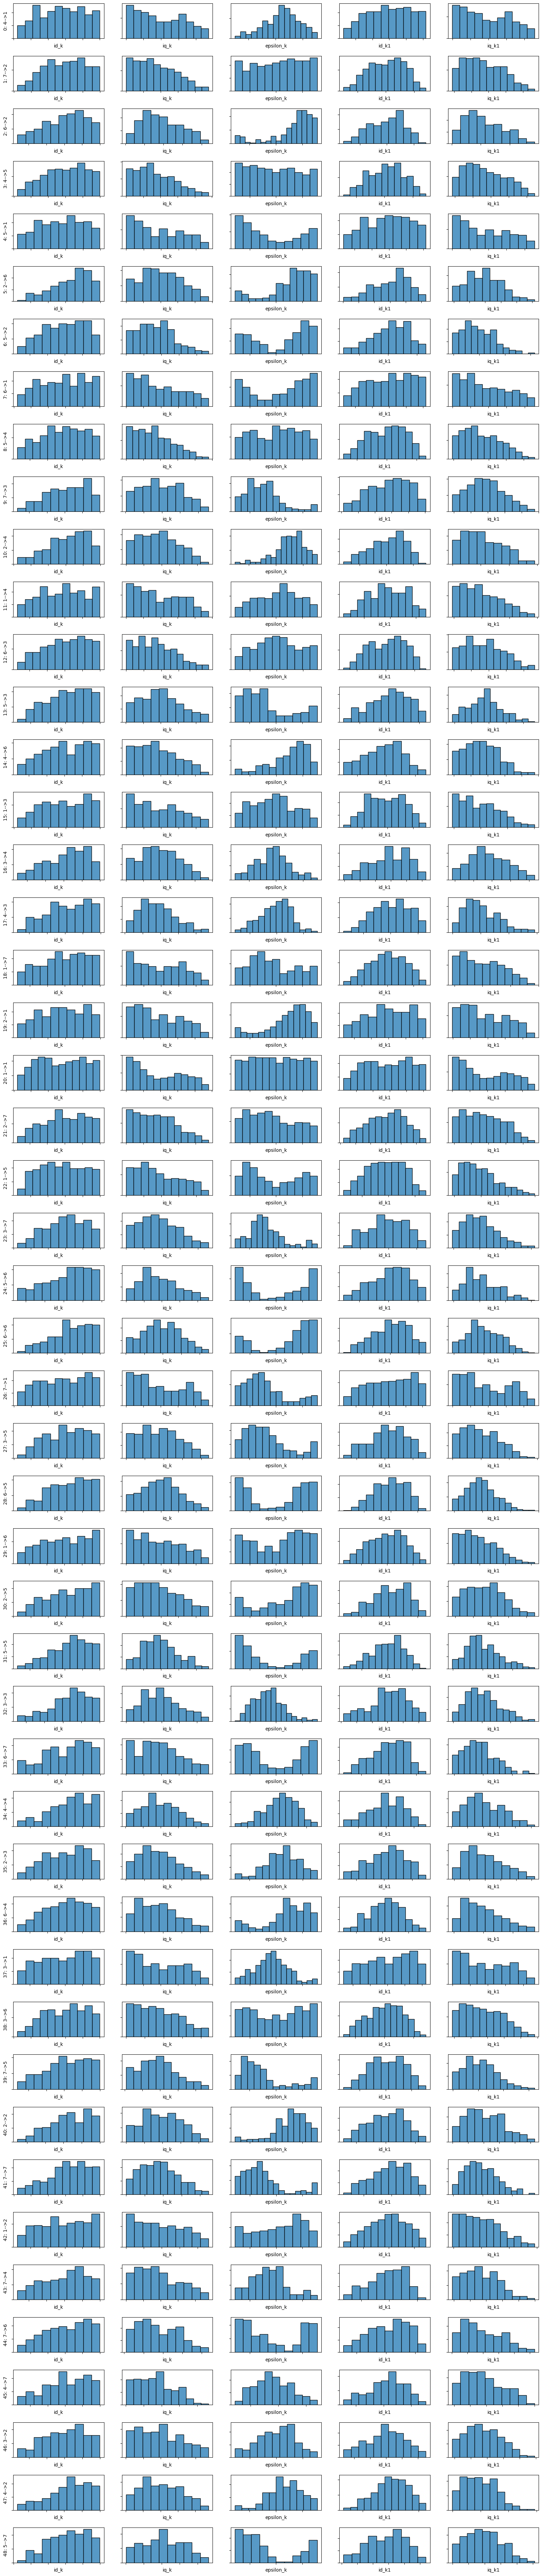

In [30]:
import matplotlib.gridspec as gridspec

group_by_column = 'state_change'
columns_model_C = [col for col in sample_df2.columns if col not in ('n_k','n_1k','state_change','state_integer')]
print(columns_model_C)

# Calculate the height of each subplot
subplot_height = 2  # Adjust this value as needed

# Create the figure and subplots with adjusted height
figure = plt.figure(figsize=(20, len(state_change_to_integer) * subplot_height))
gs = gridspec.GridSpec(len(state_change_to_integer),\
                            len(columns_model_C), figure=figure,\
                            hspace=0.5)  # hspace adjusts vertical spacing

for state, group in sample_df2.groupby('state_change'):
    for i, col in enumerate(columns_model_C):
        ax = figure.add_subplot(gs[state_change_to_integer[state], i])
        sns.histplot(data=group, x=col, ax=ax)
        ax.set(ylabel='')

        if i == 0:
            ax.set_ylabel(f'{state_change_to_integer[state]}: {state}')  # Set y-label for each row

        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

### New Features
- cos(motor angle) to make continuous
- For model B: one hot encode switch state vectors n_1k and n_k
- for Model C: one hot current switch state. Where state = tuple(n_1k, n_1k)
- Future TODO: vector norm 
- Note:
  - Typically want to apply transformations for train/test seperately.
  - Here I am transforming the data before train/test split
  - Will apply same transformations to both train/test
  - But if standardized the data would want to fit() on train data and transform on test()
  - https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset

In [31]:
X['epsilon_k'] = X['epsilon_k'].apply(lambda x: np.cos(x))
print(X.head(3))
print(X.shape)

          id_k       iq_k  epsilon_k  n_k  n_1k
0    -81.45802  229.52930  -0.620561    5     6
100 -101.20220  194.92640  -0.925331    3     6
200  -65.31933   62.02916  -0.915717    5     6
(409633, 5)


In [32]:
from sklearn.preprocessing import OneHotEncoder
# data to encode
input_df = X[['n_k','n_1k']]
# encode
encoder1 = OneHotEncoder(handle_unknown="ignore",sparse_output=False) #Test drop='first'
encoded_df1 = pd.DataFrame(encoder1.fit_transform(input_df))
# preserve index
encoded_df1.index = input_df.index
# descriptive column names
new_feature_names = encoder1.get_feature_names_out(input_df.columns.values)
encoded_df1.columns = new_feature_names
encoded_df1.columns = encoded_df1.columns.astype(str)


In [33]:
print(new_feature_names)

['n_k_1' 'n_k_2' 'n_k_3' 'n_k_4' 'n_k_5' 'n_k_6' 'n_k_7' 'n_1k_1' 'n_1k_2'
 'n_1k_3' 'n_1k_4' 'n_1k_5' 'n_1k_6' 'n_1k_7']


In [34]:
X = pd.concat([X,encoded_df1],axis=1)

In [35]:
# create a state feature
def create_state_tuple(row):
    return tuple([int(row['n_1k']),int(row['n_k'])])

X['state'] = X.apply(create_state_tuple,axis=1)

In [36]:
encoded_state_df = pd.get_dummies(X['state'], prefix='state', dummy_na=False)

In [37]:
print(encoded_state_df.columns)

Index(['state_(1, 1)', 'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)',
       'state_(1, 5)', 'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)',
       'state_(2, 2)', 'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)',
       'state_(2, 6)', 'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)',
       'state_(3, 3)', 'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)',
       'state_(3, 7)', 'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)',
       'state_(4, 4)', 'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)',
       'state_(5, 1)', 'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)',
       'state_(5, 5)', 'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)',
       'state_(6, 2)', 'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)',
       'state_(6, 6)', 'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)',
       'state_(7, 3)', 'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)',
       'state_(7, 7)'],
      dtype='object')


In [38]:
encoded_state_df = encoded_state_df.astype(int)

In [39]:
X = pd.concat([X,encoded_state_df],axis=1)

In [40]:
X.head()

,id_k,iq_k,epsilon_k,n_k,n_1k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,state,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)"
0,-81.45802,229.52930,-0.620561,5,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
100,-101.20220,194.92640,-0.925331,3,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 3)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
200,-65.31933,62.02916,-0.915717,5,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
300,-155.71220,85.02038,0.907448,3,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(4, 3)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400,-168.86510,67.30013,0.996477,1,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(7, 1)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
print(X.columns)

Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k', 'n_k_1', 'n_k_2', 'n_k_3',
       'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7', 'n_1k_1', 'n_1k_2', 'n_1k_3',
       'n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7', 'state', 'state_(1, 1)',
       'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
       'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
       'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
       'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
       'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
       'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
       'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
       'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
       'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
       'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
       'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3

# Model A - with New Features

- Features: cos(epsilon_k), id_k, iq_k, one hot encoded n_1k, n_k

In [42]:
modelA_v2_iq = LinearRegression()
modelA_v2_id = LinearRegression()

X_modelA_v2 = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7']]

X_modelA_v2.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
models_A_v2 = [{"model": modelA_v2_iq,
             "features": X_modelA_v2,
             "target": y_i_q},
             {"model": modelA_v2_id,
             "features": X_modelA_v2,
             "target": y_i_d}]

In [44]:
model_A_v2_scores = []
for m in models_A_v2:
    X_train,X_test,y_train,y_test =\
          model_selection.train_test_split(m['features'],m["target"],\
                                        train_size=0.8, random_state=1)
    model_mse = \
    evaluate_model(model = m["model"],\
                X_train = X_train, \
                X_test = X_test,\
                y_train = y_train,\
                 y_test = y_test)
    model_A_v2_scores.append(model_mse)
    print("*"*20)

print("*"*20)
print(model_A_v1_scores)

train R^2: 0.896
y =  + 0.0087*(id_k) + 0.9831*(iq_k) + -0.1205*(epsilon_k) + -3.8958*(n_k_1) + 1.1244*(n_k_2) + 0.6278*(n_k_3) + 1.1320*(n_k_4) + 0.3706*(n_k_5) + 0.2452*(n_k_6) + 0.3958*(n_k_7) + 0.2241*(n_1k_1) + 0.0103*(n_1k_2) + -0.0935*(n_1k_3) + -0.1044*(n_1k_4) + 0.0500*(n_1k_5) + 0.0316*(n_1k_6) + -0.1181*(n_1k_7) + 3.9609
test R^2: 0.896
Mean Squared Error: 393.301 A²
Mean Absolute Error: 13.627 A
********************
train R^2: 0.816
y =  + 0.9479*(id_k) + 0.0201*(iq_k) + 0.1045*(epsilon_k) + 7.6044*(n_k_1) + -1.1330*(n_k_2) + -1.6092*(n_k_3) + -1.2416*(n_k_4) + -0.8232*(n_k_5) + -1.5851*(n_k_6) + -1.2124*(n_k_7) + 0.5739*(n_1k_1) + -0.1006*(n_1k_2) + -0.0748*(n_1k_3) + 0.0525*(n_1k_4) + -0.1928*(n_1k_5) + -0.0752*(n_1k_6) + -0.1829*(n_1k_7) + -6.8518
test R^2: 0.815
Mean Squared Error: 766.968 A²
Mean Absolute Error: 22.281 A
********************
********************
[395.5499242907745, 774.3767788715248]


In [45]:
modelA_v2_test_RMSE = np.sqrt(sum(model_A_v1_scores))
print(f"Model A v2 test data RMSE: {modelA_v2_test_RMSE:.2f}")

Model A v2 test data RMSE: 34.20


# Model B
- A seperate model to predict dq currents for each elmentary vectory currently selected
- Instead of building 7 seperate model

<img src="https://images.ctfassets.net/qthuj5q9c91u/19rHdFzKHPbGNb1PGXHgax/523d80610fc908b7ebb78fc699f292af/ModelB.png" title="article4_ModelB" alt="article4_ModelB">

In [46]:
X_modelB = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7']]

df_modelB = pd.concat([X_modelB,y_i_d,y_i_q],axis=1)
# df_modelB = df_modelB.astype(int)
df_modelB = df_modelB

In [47]:
df_modelB.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,id_k1,iq_k1
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-105.73820,167.36170
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-48.62930,159.77730
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-95.14313,54.85019
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-183.91430,98.38583
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-160.16250,64.40960


In [48]:
modelB_list = ['n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7']
modelB_dfs = []
for idx,model in enumerate(modelB_list):
    filtered = df_modelB[df_modelB[model] == 1]
    modelB_dfs.append({"id":  idx+1,
                       "n_k":  model,
                      "model_data": filtered})

In [49]:
models_B_regression_data = []

for modelB_df in modelB_dfs:
    model_features = modelB_df["model_data"].iloc[:,:-2]

    column_to_drop = modelB_df["n_k"]
    model_features = model_features.drop(columns=[column_to_drop])


    model_target_iq = modelB_df["model_data"]['iq_k1']
    model_target_id = modelB_df["model_data"]['id_k1']

    regress_iq = LinearRegression()
    regress_id = LinearRegression()

    model_features_target = [{"model": regress_iq,
                              "model_name": modelB_df["n_k"]+'_iq',
                              "features": model_features,
                              "target": model_target_iq},

                            {"model": regress_id,
                            "model_name": modelB_df["n_k"]+'_id',
                            "features": model_features,
                            "target": model_target_id}]

    models_B_regression_data.append(model_features_target)

In [50]:
def run_regressions(models_data_list):
    scores = []
    for m in models_data_list:
        X_train,X_test,y_train,y_test =\
            model_selection.train_test_split(m['features'],m["target"],\
                                            train_size=0.8, random_state=1)
        model_mse = \
        evaluate_model(model = m["model"],\
                    X_train = X_train, \
                    X_test = X_test,\
                    y_train = y_train,\
                    y_test = y_test)
        scores.append({"name": m["model_name"],"test_mse": model_mse})
        print("*"*20)
        print("Test Data MSE Scores: \n")
        print(scores)
        print("-"*20)


    return scores

In [51]:
modelB_test_mse_scores = []
for model_info_list in models_B_regression_data:
    results_modelB = run_regressions(model_info_list)
    modelB_test_mse_scores.append(results_modelB)


train R^2: 1.000
y =  + -0.0043*(id_k) + 0.9739*(iq_k) + -0.0088*(epsilon_k) + 0.0000*(n_k_2) + 0.0000*(n_k_3) + 0.0000*(n_k_4) + -0.0000*(n_k_5) + 0.0000*(n_k_6) + -0.0000*(n_k_7) + 0.6976*(n_1k_1) + -0.0538*(n_1k_2) + 0.1188*(n_1k_3) + -0.3492*(n_1k_4) + 0.1610*(n_1k_5) + -0.3560*(n_1k_6) + -0.2185*(n_1k_7) + -0.5693
test R^2: 1.000
Mean Squared Error: 0.958 A²
Mean Absolute Error: 0.777 A
********************
Test Data MSE Scores: 

[{'name': 'n_k_1_iq', 'test_mse': 0.9580858229172444}]
--------------------
train R^2: 0.999
y =  + 0.9779*(id_k) + 0.0546*(iq_k) + -0.0449*(epsilon_k) + -0.0000*(n_k_2) + 0.0000*(n_k_3) + -0.0000*(n_k_4) + 0.0000*(n_k_5) + -0.0000*(n_k_6) + 0.0000*(n_k_7) + -1.6881*(n_1k_1) + 0.1389*(n_1k_2) + 0.1195*(n_1k_3) + 0.5409*(n_1k_4) + 0.0524*(n_1k_5) + 0.4349*(n_1k_6) + 0.4016*(n_1k_7) + 1.1214
test R^2: 0.999
Mean Squared Error: 4.728 A²
Mean Absolute Error: 1.735 A
********************
Test Data MSE Scores: 

[{'name': 'n_k_1_iq', 'test_mse': 0.958085822917

In [52]:
print(modelB_test_mse_scores)

[[{'name': 'n_k_1_iq', 'test_mse': 0.9580858229172444}, {'name': 'n_k_1_id', 'test_mse': 4.727991150550392}], [{'name': 'n_k_2_iq', 'test_mse': 221.22123008172377}, {'name': 'n_k_2_id', 'test_mse': 650.3918732119089}], [{'name': 'n_k_3_iq', 'test_mse': 224.43037558327887}, {'name': 'n_k_3_id', 'test_mse': 700.4094944108198}], [{'name': 'n_k_4_iq', 'test_mse': 459.9606731840886}, {'name': 'n_k_4_id', 'test_mse': 26.29008007141648}], [{'name': 'n_k_5_iq', 'test_mse': 455.51637463813324}, {'name': 'n_k_5_id', 'test_mse': 26.265266571447675}], [{'name': 'n_k_6_iq', 'test_mse': 234.91019192146123}, {'name': 'n_k_6_id', 'test_mse': 697.874348277724}], [{'name': 'n_k_7_iq', 'test_mse': 218.66694676629447}, {'name': 'n_k_7_id', 'test_mse': 644.127103093849}]]


In [53]:
print("Benchmark from first simple linear regression: ",rmse_simple_linear_regression)

Benchmark from first simple linear regression:  36.07096383084479


In [54]:
modelB_RMSE_scores = []
for model_mse_list in modelB_test_mse_scores:
    tmp = 0
    for m in model_mse_list:
        tmp = tmp + m["test_mse"]
    model_rmse = np.sqrt(tmp)
    modelB_RMSE_scores.append(model_rmse)
print(modelB_RMSE_scores)

[2.3845496374509874, 29.52309440579752, 30.41118001646925, 22.05109415098274, 21.94952485156754, 30.54152157635872, 29.37335612183503]


# Model C - One Regression Model

- Instead of running 49 regressions for each current let's use the "state column we created in the Feature Engineering section. 
- state = (n_1k, n_k): The state feature represents the elementary vector selected in the controller at time k -1, n_1k, and at time k, n_k.

<img src="https://images.ctfassets.net/qthuj5q9c91u/51al8UmQxCLPTO4i9jNBf5/4f3ccc21d35c6f713b8d691af7cbbf9b/ModelC.png" title="article4_ModelC" alt="article4_ModelC">

In [55]:
model_C_iq = LinearRegression()
model_C_id = LinearRegression()

X_model_C = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7',\
                    'state_(1, 1)',
                    'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
                    'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
                    'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
                    'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
                    'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
                    'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
                    'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
                    'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
                    'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
                    'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
                    'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3)',
                    'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)', 'state_(7, 7)'
                    ]]

X_model_C.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)"
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [56]:
models_C = [{"model": model_C_iq,
            "model_name": 'model_C_iq',
             "features": X_model_C,
             "target": y_i_q},
             {"model": model_C_id,
              "model_name": 'model_C_iq',
             "features": X_model_C,
             "target": y_i_d}]

In [57]:
results_model_C = run_regressions(models_C)
    

train R^2: 0.907
y =  + 0.0076*(id_k) + 0.9875*(iq_k) + -0.1238*(epsilon_k) + 949338047.7930*(n_k_1) + 178476982.6620*(n_k_2) + 333545050.5323*(n_k_3) + 187669167.4875*(n_k_4) + 243551883.8148*(n_k_5) + 367751257.0236*(n_k_6) + 147827931.8068*(n_k_7) + -703899691.3132*(n_1k_1) + -492208475.2630*(n_1k_2) + -349744688.6011*(n_1k_3) + -347618929.1625*(n_1k_4) + -581398060.4719*(n_1k_5) + -452916042.4731*(n_1k_6) + -422944455.8012*(n_1k_7) + -441024137.4636*(state_(1, 1)) + 329836932.2501*(state_(1, 2)) + 174768863.9017*(state_(1, 3)) + 320644747.0134*(state_(1, 4)) + 264762030.5857*(state_(1, 5)) + 140562656.6136*(state_(1, 6)) + 360485981.8719*(state_(1, 7)) + -652715354.3620*(state_(2, 1)) + 118145719.4577*(state_(2, 2)) + -36922342.8686*(state_(2, 3)) + 108953541.9801*(state_(2, 4)) + 53070800.5602*(state_(2, 5)) + -71128567.1756*(state_(2, 6)) + 148794764.2687*(state_(2, 7)) + -795179140.8077*(state_(3, 1)) + -24318084.4898*(state_(3, 2)) + -179386136.0891*(state_(3, 3)) + -33510263.5

# Poor Result - Can we do better?

- Simplified Model C to just 2 regresssion equations.
- But poor results.
- And complex regression equations, with not interpretable coefficients.

In [58]:
mse_model_C = []
for res in results_model_C:
    mse_model_C.append(res['test_mse'])

rmse_model_C = np.sqrt(sum(mse_model_C))
print(f"Model C Test RMSE: {rmse_model_C:.3f} A")

Model C Test RMSE: 32.759 A


# Model C - Many Regression Models

- Run model C as intended. A seperate model based on which elementary vector selected at time k-1 and time k.
- Thus, 49 models. Actually 49 models for q current and another 49 for i current.

<img src="https://images.ctfassets.net/qthuj5q9c91u/51al8UmQxCLPTO4i9jNBf5/4f3ccc21d35c6f713b8d691af7cbbf9b/ModelC.png" title="article4_ModelC" alt="article4_ModelC">

In [59]:
X_model_C_v2 = X_model_C.copy()

df_model_C = pd.concat([X_model_C_v2,y_i_d,y_i_q],axis=1)
# df_model_C = df_model_C.astype(int)

In [60]:
df_model_C.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)",id_k1,iq_k1
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-105.73820,167.36170
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-48.62930,159.77730
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-95.14313,54.85019
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-183.91430,98.38583
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-160.16250,64.40960


In [61]:
model_C_state_list = ['state_(1, 1)',
                    'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
                    'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
                    'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
                    'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
                    'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
                    'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
                    'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
                    'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
                    'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
                    'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
                    'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3)',
                    'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)', 'state_(7, 7)']

model_C_dataframes = []
for idx,state in enumerate(model_C_state_list):
    filtered = df_model_C[df_model_C[state] == 1]
    model_C_dataframes.append({"id":  idx+1,
                                "state":  state,
                                "model_data": filtered})

In [62]:
# Am example dataframe for state (n_1k = 1,n_k = 1)
model_C_dataframes[0]["model_data"].head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)",id_k1,iq_k1
1000,-87.88088,133.431600,0.233000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-78.85232,130.568800
2300,-177.28110,150.990700,0.978742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-164.79890,149.234100
10500,-102.40780,0.256564,-0.493012,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100.79790,-0.060439
11200,-95.74975,19.509530,-0.262145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-93.26524,19.044130
14800,-52.13607,34.013240,0.971431,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-47.97836,33.375640


In [63]:
models_C_regression_data = []

for model_C_df in model_C_dataframes:
    model_C_features = model_C_df["model_data"].loc[:,["id_k",	"iq_k","epsilon_k"]]

    model_C_target_iq = model_C_df["model_data"]['iq_k1']
    model_C_target_id = model_C_df["model_data"]['id_k1']

    regress_C_iq = LinearRegression()
    regress_C_id = LinearRegression()

    model_C_features_targets = [{"model": regress_C_iq,
                              "model_name": model_C_df["state"]+'_iq',
                              "features": model_C_features,
                              "target": model_C_target_iq},

                            {"model": regress_C_id,
                            "model_name": model_C_df["state"]+'_id',
                            "features": model_C_features,
                            "target": model_C_target_id}]

    models_C_regression_data.append(model_C_features_targets)

In [64]:
modelC_test_mse_scores = []
for model_info_list_C in  models_C_regression_data:
    results_modelC = run_regressions(model_info_list_C)
    modelC_test_mse_scores.append(results_modelC)

train R^2: 1.000
y =  + -0.0034*(id_k) + 0.9802*(iq_k) + -0.0609*(epsilon_k) + -0.3686
test R^2: 1.000
Mean Squared Error: 0.210 A²
Mean Absolute Error: 0.335 A
********************
Test Data MSE Scores: 

[{'name': 'state_(1, 1)_iq', 'test_mse': 0.21047804290676922}]
--------------------
train R^2: 1.000
y =  + 0.9863*(id_k) + 0.0505*(iq_k) + -0.1228*(epsilon_k) + 0.7802
test R^2: 1.000
Mean Squared Error: 1.639 A²
Mean Absolute Error: 1.033 A
********************
Test Data MSE Scores: 

[{'name': 'state_(1, 1)_iq', 'test_mse': 0.21047804290676922}, {'name': 'state_(1, 1)_id', 'test_mse': 1.6389539081878148}]
--------------------
train R^2: 0.942
y =  + -0.0003*(id_k) + 1.0297*(iq_k) + -23.9985*(epsilon_k) + -0.0074
test R^2: 0.944
Mean Squared Error: 276.000 A²
Mean Absolute Error: 13.567 A
********************
Test Data MSE Scores: 

[{'name': 'state_(1, 2)_iq', 'test_mse': 275.9999151657577}]
--------------------
train R^2: 0.855
y =  + 0.9691*(id_k) + 0.0270*(iq_k) + -22.0690*(eps

In [65]:
modelC_RMSE_scores = []
for model_mse_list in modelC_test_mse_scores:
    tmp = 0
    for m in model_mse_list:
        tmp = tmp + m["test_mse"]
    model_rmse = np.sqrt(tmp)
    modelC_RMSE_scores.append({"model_name": str(model_mse_list[0]["name"])[:11] ,\
                                "model_score": model_rmse})

for model_dict in modelC_RMSE_scores:
    print(model_dict)

{'model_name': 'state_(1, 1', 'model_score': 1.3599382159107758}
{'model_name': 'state_(1, 2', 'model_score': 31.35088355791121}
{'model_name': 'state_(1, 3', 'model_score': 31.337308460469245}
{'model_name': 'state_(1, 4', 'model_score': 24.921422585942622}
{'model_name': 'state_(1, 5', 'model_score': 23.977900499015934}
{'model_name': 'state_(1, 6', 'model_score': 32.57732617083595}
{'model_name': 'state_(1, 7', 'model_score': 31.68577954507129}
{'model_name': 'state_(2, 1', 'model_score': 2.4467938221158456}
{'model_name': 'state_(2, 2', 'model_score': 21.155121719805006}
{'model_name': 'state_(2, 3', 'model_score': 28.12979906488561}
{'model_name': 'state_(2, 4', 'model_score': 16.943403693108085}
{'model_name': 'state_(2, 5', 'model_score': 16.784538138840816}
{'model_name': 'state_(2, 6', 'model_score': 21.794453633547878}
{'model_name': 'state_(2, 7', 'model_score': 31.52744058009227}
{'model_name': 'state_(3, 1', 'model_score': 2.3572059528455314}
{'model_name': 'state_(3, 2', 

# Result

- A seperate model for a given state (n_1k,n_k) led to significantly improved RMSE scores.
- The individual models had fewer feature inputs.
- Able to interpret coefficients.
- State was defined as the elementary vector selected at time k-1 and time k.
- The elementary vector controls the inverter switching state which in turn operates the electric motor at a desired speed/torque.

In [66]:
model_C_avg_rmse = \
    sum([m["model_score"] for m in modelC_RMSE_scores])/len(modelC_RMSE_scores)
print(f"Average RMSE for Model C: {model_C_avg_rmse:.3f} A")

Average RMSE for Model C: 21.863 A
